In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import re
from pathlib import Path
import numpy as np
from typing import List, Dict, Tuple

from das.plotting import plot_results, set_plt_settings


RESULTS_DIR = Path("../Results_Cleaned")
PLOTS_DIR = Path("plots/mlp")

In [2]:


def aggregate_stats(
    data: List[List[Dict[str, Dict[str, float]]]]
) -> List[Dict[str, Dict[str, Tuple[float, float, float]]]]:
    if not data:
        return []

    num_items = len(data[0])
    result = []
    accuracy_data = []
    for i in range(num_items):
        accumulator: Dict[str, Dict[str, List[float]]] = {}
        _accuracy_data = []
        for seed in data:
            entry = seed[i]
            for key1, subdict in entry.items():
                if key1 == "accuracy":
                    _accuracy_data.append(subdict)
                    continue
                if key1 not in accumulator:
                    accumulator[key1] = {}
                for key2, value in subdict.items():
                    accumulator[key1].setdefault(key2, []).append(value)

        accuracy_data.append(float(np.mean(_accuracy_data)))
        # Compute (max, mean, std) for each float list
        stats_item: Dict[str, Dict[str, Tuple[float, float, float]]] = {}
        for key1, subdict in accumulator.items():
            stats_item[key1] = {}
            for key2, values in subdict.items():
                arr = np.array(values)
                max_val = float(np.max(arr))
                mean_val = float(np.mean(arr))
                std_val = float(np.std(arr, ddof=1)) if len(arr) > 1 else 0.0
                stats_item[key1][key2] = (max_val, mean_val, std_val)

        result.append(stats_item)

    return result, accuracy_data


In [11]:
Models=["Rotation","L1HS16-24","L5HS16-24","L10HS16-24","L10HS128"]
layers = ["Layer1", "Layer2", "Layer3"]
EpochNames=["Random Init",
            "EP1-B131072",
            "EP1-B262144",
            "EP1-B393216",
            "EP1-B524288",
            "EP1-B655360",
            "EP1-B786432",
            "EP1-B917504",
            "EP1-B1048576",
            "EP2-B131072",
            "EP2-B262144",
            "EP2-B393216",
            "EP2-B524288",
            "EP2-B655360",
            "EP2-B786432",
            "EP2-B917504",
            "EP2-B1048576",]

def Prepare_Data(TaskName,Model_Names,layers_label,intervention_sizes,intervention_label):
    residict={}
    accuracy=None
    for ac_model_pos,ac_Model in enumerate(Models):
        with open(RESULTS_DIR / 'TrainingProgression' / ac_Model / TaskName / 'results.json') as f:
            results= json.load(f)
        results, accuracy_data = aggregate_stats(results)
        if accuracy is None:
            # acc is the same for all models
            accuracy = accuracy_data

        for ac_train_step,ac_train_list in enumerate(results):
            if EpochNames[ac_train_step] not in residict:
                residict[EpochNames[ac_train_step]]={}
            for aclayer_pos,aclayer in enumerate(layers):
                if layers_label[aclayer_pos] not in residict[EpochNames[ac_train_step]]:
                    residict[EpochNames[ac_train_step]][layers_label[aclayer_pos]]={}
                for acint_pos, acint in enumerate(intervention_sizes):
                    if intervention_label[acint_pos] not in residict[EpochNames[ac_train_step]][layers_label[aclayer_pos]]:
                        residict[EpochNames[ac_train_step]][layers_label[aclayer_pos]][intervention_label[acint_pos]]=[[],[],[]]

                    residict[EpochNames[ac_train_step]][layers_label[aclayer_pos]][intervention_label[acint_pos]][0].append(results[ac_train_step][aclayer][acint][0])
                    residict[EpochNames[ac_train_step]][layers_label[aclayer_pos]][intervention_label[acint_pos]][1].append(results[ac_train_step][aclayer][acint][1])
                    residict[EpochNames[ac_train_step]][layers_label[aclayer_pos]][intervention_label[acint_pos]][2].append(results[ac_train_step][aclayer][acint][2])
    return residict, accuracy

def extract_training_data(data, layer, intervention, models):
    """Extracts means, stds, and max values for a specific metric across training epochs."""
    epochs_raw = list(data.keys())
    num_models = len(models)
    # Sort epochs: 'Random Init' first, then EPx-Byyy sorted numerically
    def sort_key(epoch_name):
        if epoch_name == 'Random Init':
            return (0, 0, 0) # Ensure it's first
        match = re.match(r'EP(\d+)-B(\d+)', epoch_name)
        if match:
            ep_num = int(match.group(1))
            batch_num = int(match.group(2))
            return (1, ep_num, batch_num) # Sort by type, then epoch, then batch
        print(f"Warning: Unrecognized epoch format: {epoch_name}")
        return (2, 0, 0) # Place unrecognized formats last

    sorted_epochs = sorted(epochs_raw, key=sort_key)

    plot_data_mean = {}
    plot_data_std = {}
    plot_data_max = {}

    for epoch in sorted_epochs:
        try:
            # Access the mean list (index 0), std list (index 1), and max list (index 2)
            data_point = data[epoch][layer][intervention]
            max_list, means_list, stds_list = data_point[0], data_point[1], data_point[2]

            if len(means_list) == num_models and len(stds_list) == num_models and len(max_list) == num_models:
                 plot_data_mean[epoch] = means_list
                 plot_data_std[epoch] = stds_list
                 plot_data_max[epoch] = max_list
            else:
                # Handle potential length mismatches if data is inconsistent
                print(f"Warning: Data length mismatch in {epoch}/{layer}/{intervention}. Expected {num_models}, got {len(means_list)}. Padding with NaN.")
                plot_data_mean[epoch] = (means_list + [np.nan]*num_models)[:num_models]
                plot_data_std[epoch] = (stds_list + [np.nan]*num_models)[:num_models]
                plot_data_max[epoch] = (max_list + [np.nan]*num_models)[:num_models]

        except (KeyError, IndexError, TypeError) as e:
            print(f"Warning: Could not extract data for {epoch}/{layer}/{intervention}. Error: {e}. Filling with NaN.")
            plot_data_mean[epoch] = [np.nan] * num_models
            plot_data_std[epoch] = [np.nan] * num_models
            plot_data_max[epoch] = [np.nan] * num_models

    # Create DataFrames
    mean_df = pd.DataFrame.from_dict(plot_data_mean, orient='index', columns=models)
    std_df = pd.DataFrame.from_dict(plot_data_std, orient='index', columns=models)
    max_df = pd.DataFrame.from_dict(plot_data_max, orient='index', columns=models)

    # Drop rows where all values are NaN (might happen if an epoch had missing data)
    mean_df.dropna(axis=0, how='all', inplace=True)
    std_df = std_df.reindex(mean_df.index) # Ensure std_df matches filtered mean_df index
    max_df = max_df.reindex(mean_df.index) # Ensure max_df matches filtered mean_df index

    return max_df, mean_df, std_df


def plot_layer_intervention(results, accuracy_data, target_layer, target_intervention, out_file_name, collapse_strategy="max"):
    # Determine number of models/seeds from data structure
    try:
        first_epoch_key = next(iter(results))
        num_models = len(results[first_epoch_key][target_layer][target_intervention][0])
        print(f"Detected {num_models} models/seeds per data point.")
    except (StopIteration, KeyError, IndexError, TypeError):
        print("Warning: Could not determine number of models automatically. Defaulting to 1.")
        num_models = 1
    # Extract the data for the chosen layer/intervention
    metric_max_df, metric_mean_df, metric_std_df = extract_training_data(results, target_layer, target_intervention, Model_Names)
    x_coords_map = {epoch: i for i, epoch in enumerate(metric_mean_df.index)}
    if collapse_strategy == "max":
        df = metric_max_df
    elif collapse_strategy == "mean":
        df = metric_mean_df
    elif collapse_strategy == "std":
        df = metric_std_df
    else:
        raise ValueError(f"Invalid collapse strategy: {collapse_strategy}")

    accuracy_df = pd.DataFrame(accuracy_data, index = EpochNames, columns = ["Accuracy"])

    # Define a simple label replacement for epochs if desired (optional)
    def format_epoch_label(s):
        if s == 'Random Init':
            return 'Step 0'
        s = s.replace('-B', '/') # Shorten label
        # Potentially convert large batch numbers to scientific notation or k/M units
        parts = s.split('/')
        if len(parts) == 2:
            try:
                batch_num = int(parts[1])
                if batch_num >= 1_000_000:
                        s = f"{batch_num/1_000_000:.0f}M"
                elif batch_num >= 1000:
                        s = f"{batch_num/1000:.0f}k"
            except ValueError:
                pass # Keep original if batch number isn't integer
        return s
    
    fig, ax = plot_results(
        iia_df=df,
        acc_df=accuracy_df,      # No separate accuracy markers needed here
        iia_std_df=pd.DataFrame(),   # Standard deviations for error bands
        x_coords_map=x_coords_map,
        # Use a descriptive Y label based on what the metric actually is
        y_label=f"Accuracy",
        error_bar_alpha=0.15,        # Adjust transparency of error bands
        error_bar_multiplier=1.0,    # Show +/- 1 standard deviation
        xtick_label_rotation=0,
        xtick_label_fontsize=24,
        ytick_label_fontsize=24,
        xlabel_fontsize=24,
        ylabel_fontsize=24,
        x_label="Model Training Steps",
        legend_font_size=18,
        legend_loc_final='lower right', # Adjust legend position
        legend_bbox_final=(1.0, 0.0),   # Adjust legend position
        figsize=(8, 4.5),              # Adjust figure size
        inject_color_at_start=(0, 204/255, 102/255),
        acc_marker_color="red",
        acc_marker_label="Model Acc.",
        x_axis_label_pad=10
        # xtick_label_replace=format_epoch_label, # Apply custom label formatting
    )

    # --- X-axis Tick Customization (as requested) ---
    # Only show labels for the first and last training steps plotted
    if len(metric_mean_df.index) > 1:
        start_epoch_label = metric_mean_df.index[0]
        end_epoch_label = metric_mean_df.index[-1]
        start_pos = x_coords_map[start_epoch_label]
        end_pos = x_coords_map[end_epoch_label]

        # Get formatted labels if replacement function is used
        formatted_start = "0"
        formatted_end = "Full"

        labels = ["" for _ in range(len(metric_mean_df.index))]
        labels[0] = formatted_start
        labels[len(labels)//2] = format_epoch_label(metric_mean_df.index[len(labels)//2])
        labels[-1] = formatted_end
        ax.set_xticklabels(labels, rotation=0, ha="center")
        print(f"Customized x-axis ticks to show only: {formatted_start}, {formatted_end}")
    elif len(metric_mean_df.index) == 1:
            start_epoch_label = metric_mean_df.index[0]
            start_pos = x_coords_map[start_epoch_label]
            formatted_start = format_epoch_label(start_epoch_label)
            ax.set_xticks([start_pos])
            ax.set_xticklabels([formatted_start], rotation=45, ha="right")


    # Optional: Adjust Y-axis limits if needed
    # ax.set_ylim(0.4, 1.01)
    set_plt_settings()

    fig.tight_layout() # Adjust layout to prevent overlap
    fig.savefig(out_file_name, bbox_inches='tight')
    plt.show()

## Plot for Both Equality Relations

In [12]:
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 8"]
Model_Names=["Rotation","$K=1,d_\\mathrm{h}=2^4$","$K=5,d_\\mathrm{h}=2^4$","$K=10,d_\\mathrm{h}=2^4$","$K=10,d_\\mathrm{h}=2^7$"]
TaskName="Both_Equality_Relations"
results, accuracy_data = Prepare_Data(TaskName,Model_Names,layers_label,intervention_sizes,intervention_label)

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


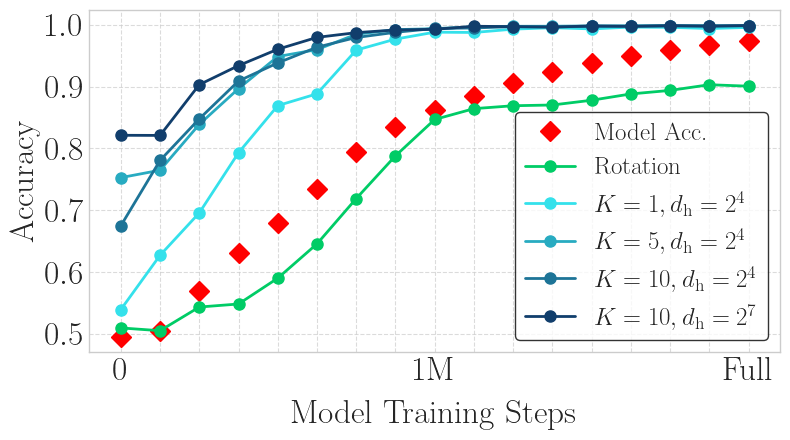

In [13]:
plot_layer_intervention(results, accuracy_data, "Layer 1", "Intervetion Size 8", PLOTS_DIR / f"training_progression_{TaskName}_test_test.pdf".replace(" ", "_"))

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


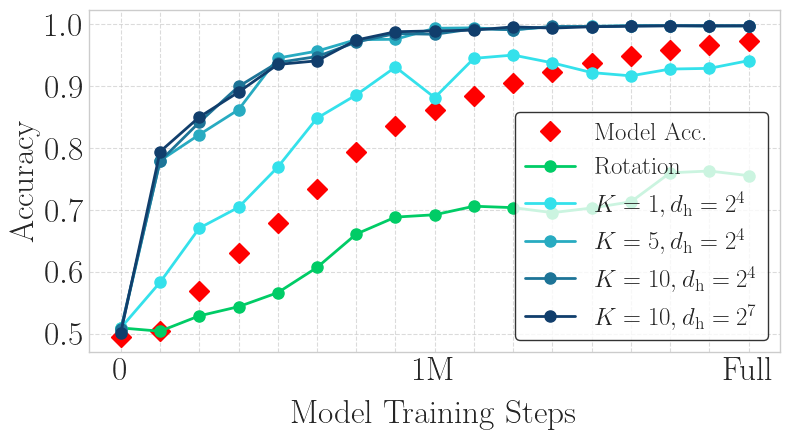

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


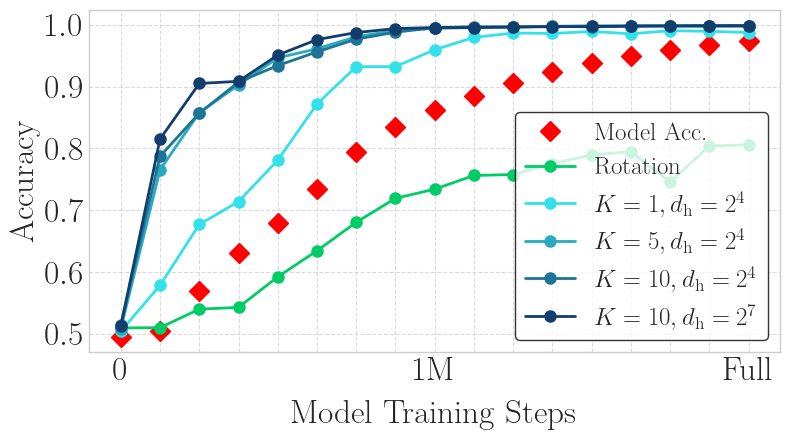

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


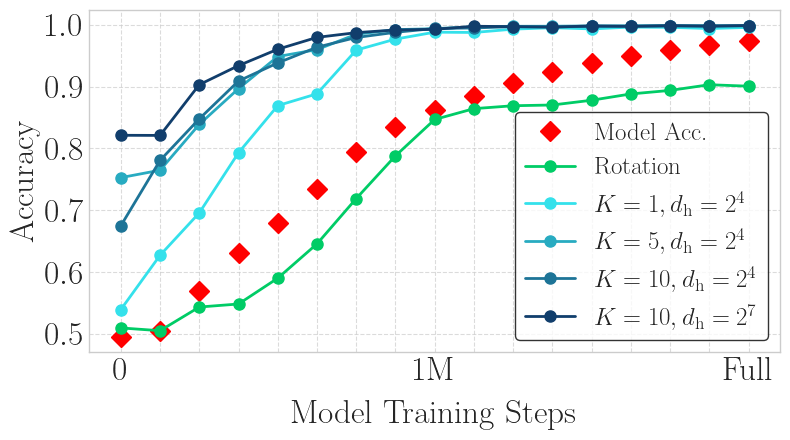

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


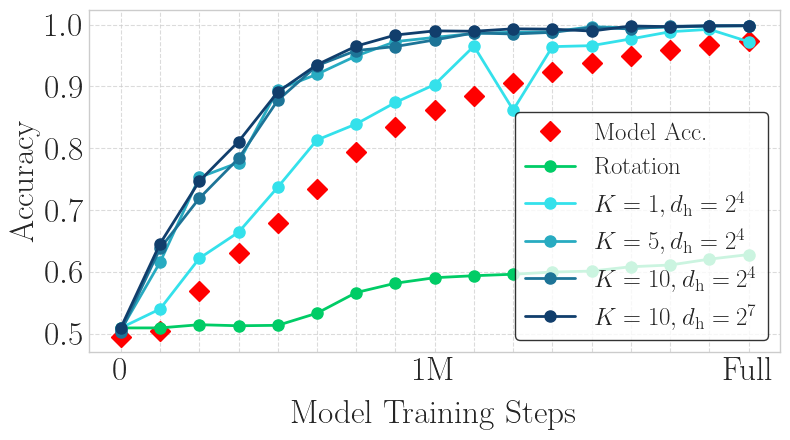

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


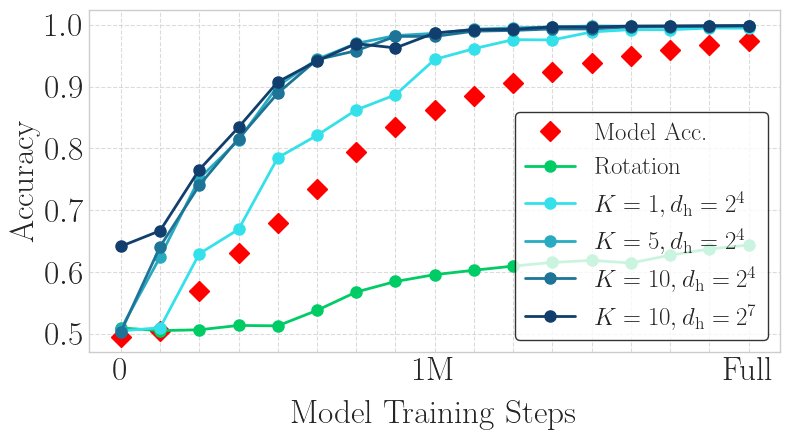

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


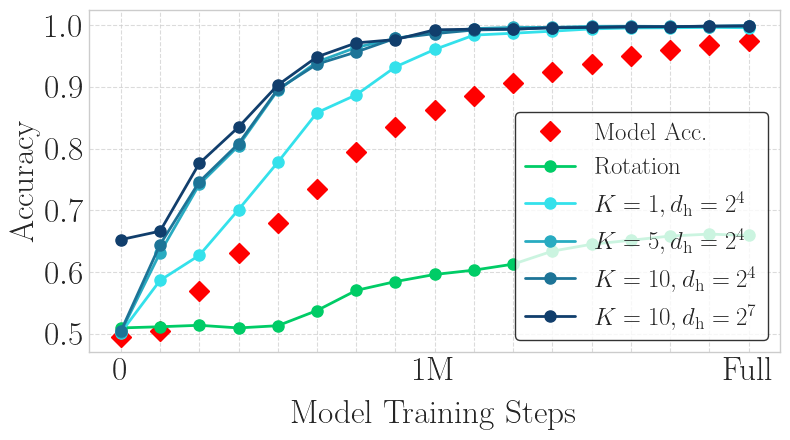

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


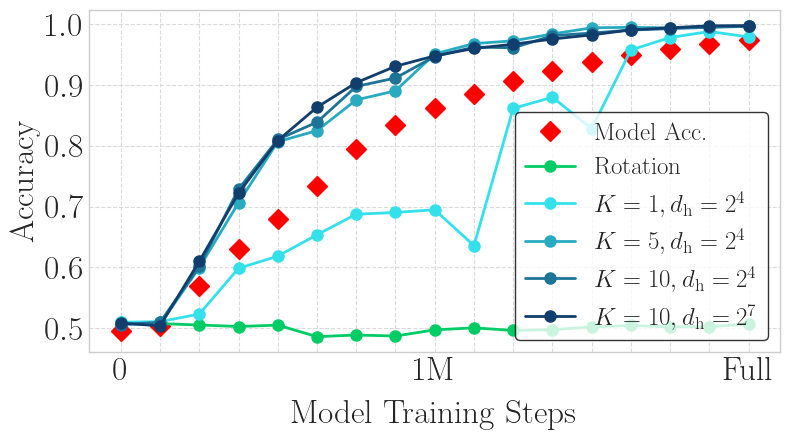

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


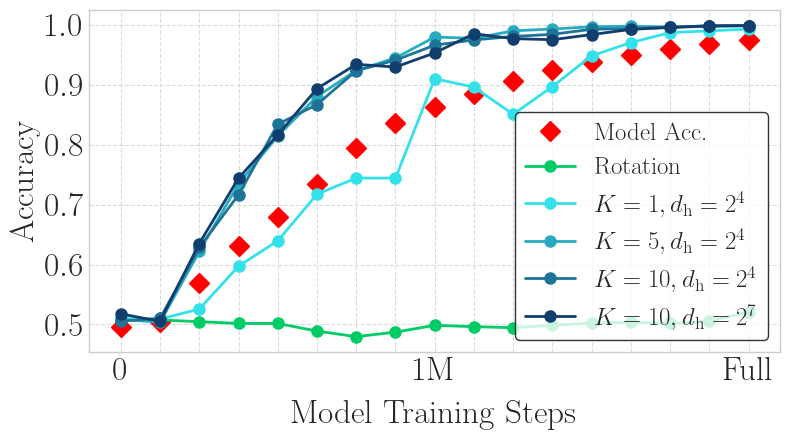

Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: 0, Full


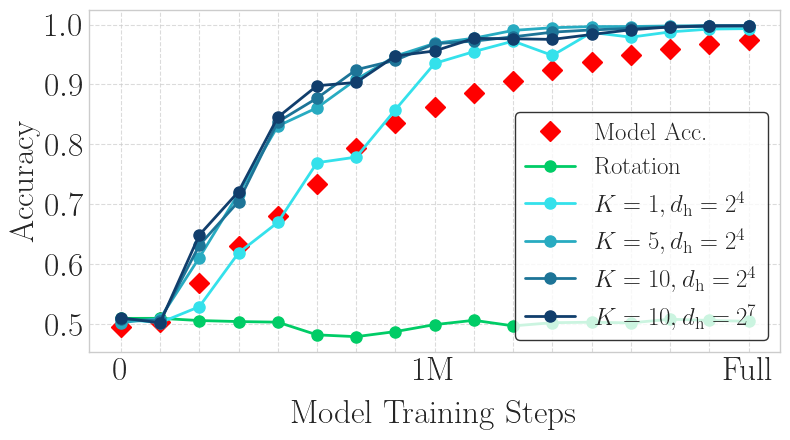

In [14]:
for layer in layers_label:
    for intervention in intervention_label:
        plot_layer_intervention(results, accuracy_data, layer, intervention, PLOTS_DIR / f"training_progression_{TaskName}_{layer}_{intervention}.pdf".replace(" ", "_"))


Detected 5 models/seeds per data point.
Adding diamond legend entry for Model Acc.
Customized x-axis ticks to show only: Step 0, Full


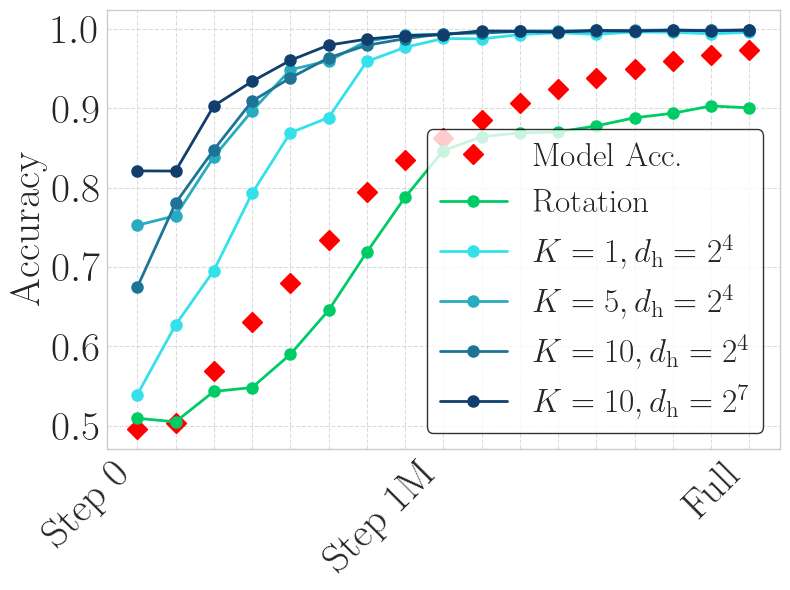

In [ ]:
target_layer = 'Layer 1'
target_intervention = 'Intervetion Size 8'
# Determine number of models/seeds from data structure
try:
    first_epoch_key = next(iter(results))
    num_models = len(results[first_epoch_key][target_layer][target_intervention][0])
    print(f"Detected {num_models} models/seeds per data point.")
except (StopIteration, KeyError, IndexError, TypeError):
    print("Warning: Could not determine number of models automatically. Defaulting to 1.")
    num_models = 1
# Extract the data for the chosen layer/intervention
metric_max_df, metric_mean_df, metric_std_df = extract_training_data(results, target_layer, target_intervention, Model_Names)
x_coords_map = {epoch: i for i, epoch in enumerate(metric_mean_df.index)}

# Define a simple label replacement for epochs if desired (optional)
def format_epoch_label(s):
    if s == 'Random Init':
        return 'Step 0'
    s = s.replace('-B', '/') # Shorten label
    # Potentially convert large batch numbers to scientific notation or k/M units
    parts = s.split('/')
    if len(parts) == 2:
        try:
            batch_num = int(parts[1])
            if batch_num >= 1_000_000:
                    s = f"Step {batch_num/1_000_000:.0f}M"
            elif batch_num >= 1000:
                    s = f"Step {batch_num/1000:.0f}k"
        except ValueError:
            pass # Keep original if batch number isn't integer
    return s

set_plt_settings()
fig, ax = plot_results(
    iia_df=metric_max_df,
    acc_df=accuracy_df,      # No separate accuracy markers needed here
    iia_std_df=pd.DataFrame(),   # Standard deviations for error bands
    x_coords_map=x_coords_map,
    # Use a descriptive Y label based on what the metric actually is
    y_label=f"Accuracy",
    error_bar_alpha=0.15,        # Adjust transparency of error bands
    error_bar_multiplier=1.0,    # Show +/- 1 standard deviation
    xtick_label_rotation=45,
    xtick_label_fontsize=30,
    ytick_label_fontsize=30,
    xlabel_fontsize=30,
    ylabel_fontsize=30,
    x_label="",
    legend_font_size=24,
    legend_loc_final='lower right', # Adjust legend position
    legend_bbox_final=(1.0, 0.0),   # Adjust legend position
    figsize=(8, 6),              # Adjust figure size
    inject_color_at_start=(0, 204/255, 102/255),
    acc_marker_color="red",
    acc_marker_label="Model Acc.",
    # xtick_label_replace=format_epoch_label, # Apply custom label formatting
)

# --- X-axis Tick Customization (as requested) ---
# Only show labels for the first and last training steps plotted
if len(metric_mean_df.index) > 1:
    start_epoch_label = metric_mean_df.index[0]
    end_epoch_label = metric_mean_df.index[-1]
    start_pos = x_coords_map[start_epoch_label]
    end_pos = x_coords_map[end_epoch_label]

    # Get formatted labels if replacement function is used
    formatted_start = "Step 0"
    formatted_end = "Full"

    labels = ["" for _ in range(len(metric_mean_df.index))]
    labels[0] = formatted_start
    labels[len(labels)//2] = format_epoch_label(metric_mean_df.index[len(labels)//2])
    labels[-1] = formatted_end
    ax.set_xticklabels(labels, rotation=45, ha="right")
    print(f"Customized x-axis ticks to show only: {formatted_start}, {formatted_end}")
elif len(metric_mean_df.index) == 1:
        start_epoch_label = metric_mean_df.index[0]
        start_pos = x_coords_map[start_epoch_label]
        formatted_start = format_epoch_label(start_epoch_label)
        ax.set_xticks([start_pos])
        ax.set_xticklabels([formatted_start], rotation=45, ha="right")


# Optional: Adjust Y-axis limits if needed
# ax.set_ylim(0.4, 1.01)
set_plt_settings()
 # Set LaTeX font for high-quality publication-ready plots
 
# # Apply LaTeX formatting to axis labels and ticks with font size 35
# ax.set_xlabel(ax.get_xlabel(), fontsize=30)
# ax.set_ylabel(ax.get_ylabel(), fontsize=30)
# ax.tick_params(axis='both', which='major', labelsize=30)
# Make the legend background slightly transparent
ax.get_legend().get_frame().set_alpha(0.8)  # Set transparency level (0.0 is fully transparent, 1.0 is opaque)

fig.tight_layout() # Adjust layout to prevent overlap
fig.savefig(f"plots/mlp_training_progression_plots.png", bbox_inches='tight')

In [30]:
metric_mean_df

,Model 1,Model 2,Model 3,Model 4,Model 5
Random Init,0.50180,0.50076,0.50070,0.50202,0.49914
EP1-B131072,0.49992,0.53376,0.65572,0.72602,0.70208
EP1-B262144,0.50940,0.59292,0.76796,0.76460,0.75272
EP1-B393216,0.51934,0.65490,0.81890,0.82270,0.86422
EP1-B524288,0.53872,0.70532,0.88230,0.88044,0.91428
EP1-B655360,0.56734,0.72710,0.93402,0.92518,0.93418
EP1-B786432,0.58990,0.73228,0.94690,0.94628,0.96648
EP1-B917504,0.60070,0.78312,0.96156,0.96924,0.97406
EP1-B1048576,0.60694,0.81568,0.97032,0.97146,0.97040
EP2-B131072,0.62222,0.83110,0.98380,0.96978,0.97852


Detected 5 models/seeds per data point.
Accuracy DataFrame is empty. Plotting IIA only if available.
Customized x-axis ticks to show only: Step 0, Full


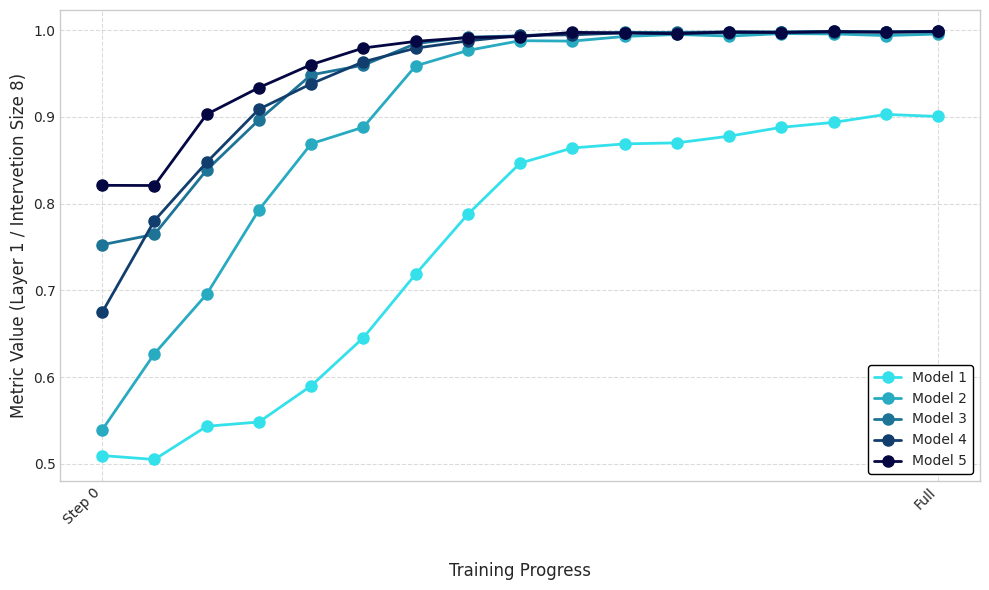

In [ ]:
target_layer = 'Layer 1'
target_intervention = 'Intervetion Size 8'
# Determine number of models/seeds from data structure
try:
    first_epoch_key = next(iter(results))
    num_models = len(results[first_epoch_key][target_layer][target_intervention][0])
    print(f"Detected {num_models} models/seeds per data point.")
except (StopIteration, KeyError, IndexError, TypeError):
    print("Warning: Could not determine number of models automatically. Defaulting to 1.")
    num_models = 1
# Extract the data for the chosen layer/intervention
metric_max_df, metric_mean_df, metric_std_df = extract_training_data(results, target_layer, target_intervention, num_models)
x_coords_map = {epoch: i for i, epoch in enumerate(metric_mean_df.index)}

# Define a simple label replacement for epochs if desired (optional)
def format_epoch_label(s):
    if s == 'Random Init':
        return 'Step 0'
    s = s.replace('EP', 'E').replace('-B', '/') # Shorten label
    # Potentially convert large batch numbers to scientific notation or k/M units
    parts = s.split('/')
    if len(parts) == 2:
        try:
            batch_num = int(parts[1])
            if batch_num >= 1_000_000:
                    s = f"{parts[0]}/{batch_num/1_000_000:.1f}M"
            elif batch_num >= 1000:
                    s = f"{parts[0]}/{batch_num/1000:.0f}k"
        except ValueError:
            pass # Keep original if batch number isn't integer
    return s

fig, ax = plot_results(
    iia_df=metric_max_df,      # Primary data (means) plotted as lines
    acc_df=pd.DataFrame(),      # No separate accuracy markers needed here
    iia_std_df=pd.DataFrame(),   # Standard deviations for error bands
    x_coords_map=x_coords_map,
    x_label="Training Progress",
    # Use a descriptive Y label based on what the metric actually is
    y_label=f"Metric Value ({target_layer} / {target_intervention})",
    title=f"Training Progress ({target_layer} / {target_intervention})",
    error_bar_alpha=0.15,        # Adjust transparency of error bands
    error_bar_multiplier=1.0,    # Show +/- 1 standard deviation
    xtick_label_rotation=45,
    xtick_label_fontsize=10,
    ytick_label_fontsize=10,
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    title_fontsize=14,
    legend_font_size=10,
    legend_loc_final='lower right', # Adjust legend position
    legend_bbox_final=(1.0, 0.0),   # Adjust legend position
    figsize=(10, 6),              # Adjust figure size
    # xtick_label_replace=format_epoch_label, # Apply custom label formatting
)

# --- X-axis Tick Customization (as requested) ---
# Only show labels for the first and last training steps plotted
if len(metric_mean_df.index) > 1:
    start_epoch_label = metric_mean_df.index[0]
    end_epoch_label = metric_mean_df.index[-1]
    start_pos = x_coords_map[start_epoch_label]
    end_pos = x_coords_map[end_epoch_label]

    # Get formatted labels if replacement function is used
    formatted_start = format_epoch_label(start_epoch_label)
    formatted_end = "Full"

    ax.set_xticks([start_pos, end_pos])
    ax.set_xticklabels([formatted_start, formatted_end], rotation=45, ha="right")
    print(f"Customized x-axis ticks to show only: {formatted_start}, {formatted_end}")
elif len(metric_mean_df.index) == 1:
        start_epoch_label = metric_mean_df.index[0]
        start_pos = x_coords_map[start_epoch_label]
        formatted_start = format_epoch_label(start_epoch_label)
        ax.set_xticks([start_pos])
        ax.set_xticklabels([formatted_start], rotation=45, ha="right")


fig.tight_layout() # Adjust layout to prevent overlap


In [25]:

def make_plot(results, mean_data, hiddensize_range,layers,intervention_sizes,url):
    sub_y_min = 0.4
    sub_y_max = 1
    meancolor = (0/255, 128/255, 255/255)
    std_color = (52/255, 225/255, 235/255)
    rotationmean_color = (0/255, 153/255, 0/255)
    # Create a 3x3 grid for subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    
    # Iterate over the plot_data dictionary to create subplots
    for i, layer in enumerate(results):
        for j, label in enumerate(results[layer]):
            ax = axes[i, j]
            
            y_values_mean = results[layer][label][0]
            y_values_std = results[layer][label][1]
            
            # Plot the mean values
            ax.plot(hiddensize_range, y_values_mean, marker='o', color=meancolor)
            constant_y = mean_data[layers[i]][intervention_sizes[j]][0]
            ax.axhline(y=constant_y, color=rotationmean_color, linestyle='--', linewidth=2)
            
            # Add the standard deviation shading (±3 std)
            upper_bound = [m + 2*s for m, s in zip(y_values_mean, y_values_std)]
            lower_bound = [m - 2*s for m, s in zip(y_values_mean, y_values_std)]
            ax.fill_between(hiddensize_range, lower_bound, upper_bound, 
                color=std_color, alpha=0.5, linewidth=0)
            
            ax.set_ylim(sub_y_min, sub_y_max)
            
            if i != 2:
                ax.set_xlabel('')
                ax.set_xticks([])
            else:
                ax.set_xlabel(label)
                
            if j != 0:
                ax.set_ylabel('')
                ax.set_yticks([])
            else:
                ax.set_ylabel(layer)
            
            #plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    # Save the plot
    plt.savefig(url, bbox_inches='tight')
    plt.show()
    plt.close()




def make_plot_single_layer(results, mean_data, target_layer, intervention_sizes, out_file_name):
    layer_data = results.get(target_layer)
    if layer_data:
        num_points = len(layer_data[next(iter(layer_data.keys()))][0])
        print(num_points)
        hidden_sizes_index = [i+1 for i in range(num_points)]
        layer_data = results.get(target_layer)
        mean_data_for_df = {}
        std_data_for_df = {}
        intervention_sizes = [] # Keep track of column order

        for intervention_key, (means, stds) in layer_data.items():
            intervention_sizes.append(intervention_key)
            if len(means) == len(hidden_sizes_index) and len(stds) == len(hidden_sizes_index):
                mean_data_for_df[intervention_key] = means
                std_data_for_df[intervention_key] = stds
            else:
                print(f"Warning: Data length mismatch for {intervention_key}. Expected {len(hidden_sizes_index)}, got {len(means)}. Skipping.")

        # Create DataFrames with the defined index
        iia_mean_df = pd.DataFrame(mean_data_for_df, index=hidden_sizes_index)
        iia_std_df = pd.DataFrame(std_data_for_df, index=hidden_sizes_index)

        # Ensure columns are in a consistent order (optional but good practice)
        iia_mean_df = iia_mean_df[intervention_sizes]
        iia_std_df = iia_std_df[intervention_sizes]

        # Create the mapping for x-coordinates (using simple numeric positions)
        x_coords_map = {label: i for i, label in enumerate(hidden_sizes_index)}

        # --- Plotting ---
        # Use the modified plot_results function

        fig, ax = plot_results(
            iia_df=iia_mean_df,
            acc_df=pd.DataFrame(), # No accuracy data in this specific example format
            iia_std_df=iia_std_df, # Pass the standard deviation data
            x_coords_map=x_coords_map,
            x_label="$d_{\\mathrm{hidden}}$", # Customize axis label
            y_label="Accuracy", # Customize axis label
            title=f"Results for {target_layer}", # Customize title
            error_bar_alpha=0.25, # Customize alpha
            error_bar_multiplier=1.0, # Plot +/- 1 std dev
            # Add any other plot_results customization parameters as needed
            legend_font_size=24,
            xtick_label_rotation=0,
            figsize=(8, 6)
        )
        
        # Add a single legend entry for the reference lines
        ax.plot([], [], color='black', linestyle='--', linewidth=2, label='Accuracy')
        
        ax.tick_params(axis='both', which='major', labelsize=30)
        # Set axis label sizes
        ax.set_xlabel(ax.get_xlabel(), fontsize=30)
        ax.set_ylabel(ax.get_ylabel(), fontsize=30)
        
        # Set title size if needed
        ax.set_title(ax.get_title(), fontsize=32)
        # Set x-axis ticks to show only powers of 2 and 1
        power_of_2_ticks = [1, 2, 4, 8, 16]
        ax.set_xticks([el-1 for el in power_of_2_ticks])
            
        # Adjust horizontal alignment of tick labels to center them properly
        for label in ax.get_xticklabels():
            label.set_ha('center')

        set_plt_settings()
        
        plt.tight_layout()
        plt.draw()
        
        fig.savefig(out_file_name, bbox_inches='tight')
    
        return fig, ax

    else:
        print(f"Error: Data for layer '{target_layer}' not found in results.")

## Plot for Both Equality Relations

16
Accuracy DataFrame is empty. Plotting IIA only if available.
16
Accuracy DataFrame is empty. Plotting IIA only if available.
16
Accuracy DataFrame is empty. Plotting IIA only if available.


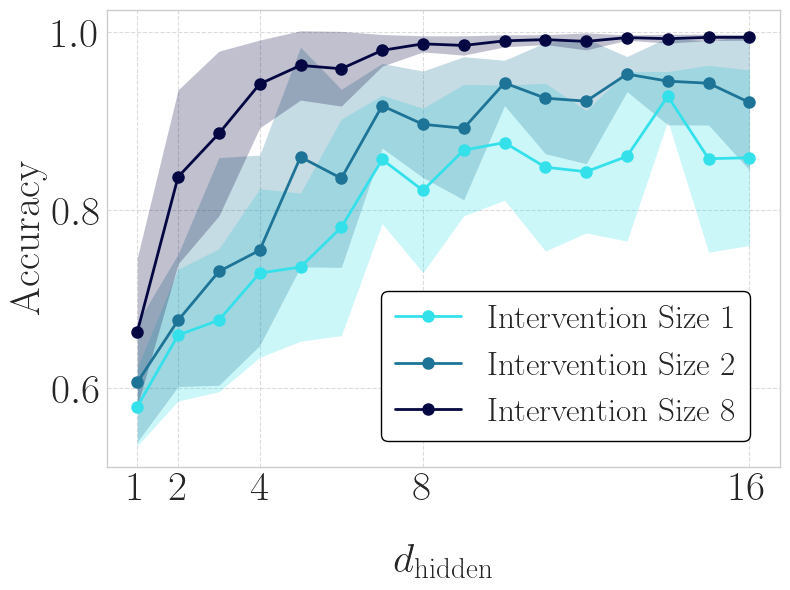

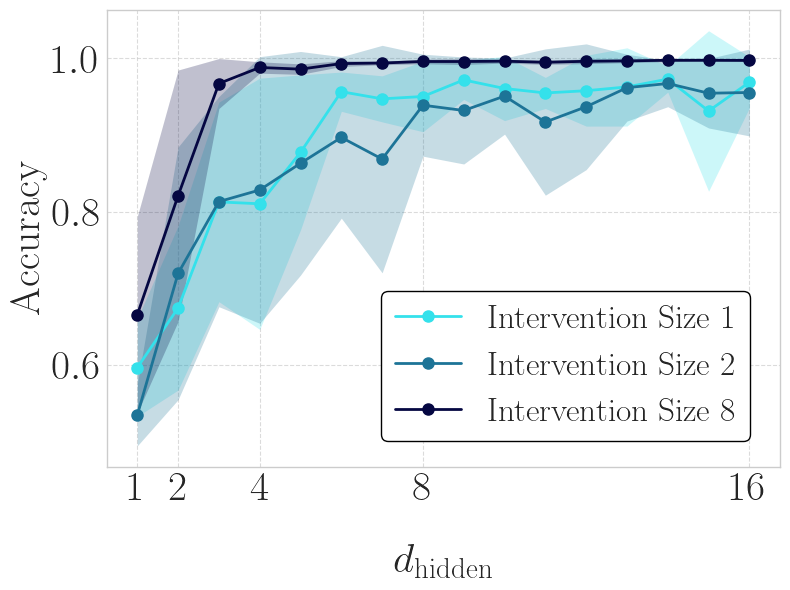

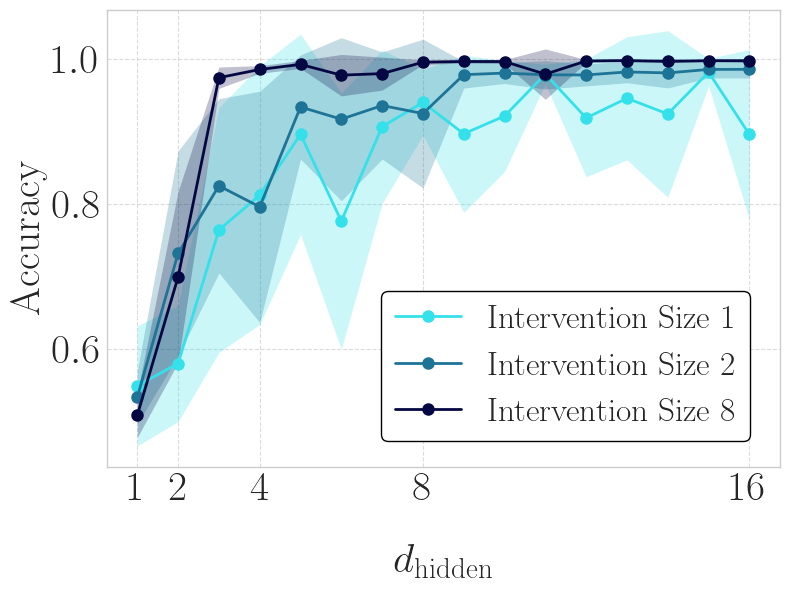

In [27]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervention Size 1","Intervention Size 2","Intervention Size 8"]
hiddensize_range=list(range(1,17))

with open(RESULTS_DIR / 'HiddenSizeProgression/Both_Equality_Relations/results_1.json') as f:
    results1= json.load(f)
with open(RESULTS_DIR / 'HiddenSizeProgression/Both_Equality_Relations/results_2.json') as f:
    results2= json.load(f)
with open(RESULTS_DIR / 'Standard_DAS/Rotation/FullyTrained/Both_Equality_Relations/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)

PLOTS_DIR.mkdir(parents=True, exist_ok=True)
for layer in layers_label:
    fig, ax = make_plot_single_layer(results, mean_data, layer, intervention_sizes, PLOTS_DIR / f'hidden_size_both_equality_relations_{layer}.pdf'.replace(" ", "_"))


## Plot for Left Equality Relation

In [6]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 8"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/Left_Equality_Relation/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/Left_Equality_Relation/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/Left_Equality_Relation/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_Left_Equality_Relation.png")

## Plot for Identity of First Argument

In [7]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0]]',
                        '[[0, 1]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 8"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/Identity_of_First_Argument/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/Identity_of_First_Argument/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/Identity_of_First_Argument/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_Identity_of_First_Argument.png")

## Plot for AndOrAnd

In [8]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 12"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/AndOrAnd/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/AndOrAnd/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/AndOrAnd/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_AndOrAnd.png")

## Plot for AndOrAnd

In [9]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 12"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/AndOr/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/AndOr/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/AndOr/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_AndOr.png")